# Doing quick surface photometry of a galaxy given its coordinates

Owners: **Aaron Watkins, Nushkia Chamba**  
Last Verified to Run: **13 August 2020**  
Verified Stack release: **20.0.0+7**

### Objectives: 

This worksheet is a demonstration of how to do the following:
1. Locate a specific object from available databases in the Stack using its right ascension and declination coordinates
2. Obtain a thumbnail of the object for image analysis
3. Mask unwanted sources surrounding and overlapping the object using source detection footprints and Bokeh
4. Do quick surface photometry of the object on the masked image, with a local background estimation

The basic goal is to provide a demonstration of one way to perform one's own image analysis within the Stack, on present and future imaging data releases.  It can be used as a stepping off point for development of one's own software.

## **Initial Setup**

In [ ]:
# What version of the Stack am I using?
! echo $HOSTNAME
! eups list lsst_distrib -s

### **Packages and dependencies**

In [27]:
# Image retrieval tasks
from lsst.obs.hsc.hscMapper import HscMapper
import lsst.daf.persistence as dafPersist
from lsst.daf.persistence import Butler
import lsst.afw.table as afwTable
import lsst.afw.display as afwDisplay
import lsst.afw.detection as afwDetection
import lsst.geom as geom
from lsst.geom import Box2D
from lsst.afw.image import Exposure, Image, PARENT, MultibandExposure, MultibandImage

# Detection and deblending tasks
from lsst.meas.algorithms import SourceDetectionTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.afw.table import SourceCatalog
import scarlet
import scarlet.display
import lsst.meas.extensions.scarlet as mes
from scarlet_extensions.initialization import detection as det

# All other (non-lsst) tasks
import os
import sys
import glob
from copy import copy
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Ellipse
from IPython.display import display, Markdown
import numpy as np
from astropy.table import Table
import astropy.coordinates as coord
from astropy.visualization import make_lupton_rgb

afwDisplay.setDefaultBackend('matplotlib')

One final dependency is the following:
https://github.com/herjy/scarlet_extensions

Git clone this, then move the scarlet_extensions subdirectory into this notebook's directory to perform the deblending aspects of this notebook.

This package requires SEP (SExtractor for Python).  In an LSST terminal, do `pip install sep`.

### **Functions**

Now we will define some functions, in advance, to do the actual surface photometry.  We will be focusing on galaxies, hence require a way to transform the thumbnail images into in-plane galaxy coordinates and a way to measure the light profiles in those coordinates.

We also borrow a function from the notebook in the repo: StackClub/Deblending/lsst_stack_deblender.ipynb to create RGB images. 
To create the RGB image itself, this function uses the make_lupton_rgb function in astropy. However, the RGB image from this function consistently makes galaxies more red than their global colours suggest. Therefore, in this notebook we manually scale the individual rgb channels prior to input and thus improve the quality of the resulting RGB image. 
We add a 'scale' parameter to do this in the following showRGB function taken from the StackClub repo cited here.

Inspiration for exploring a 'scale' parameter stemmed from Lee Kelvin's 'plotfits' code in the R programming language: https://rdrr.io/cran/astro/man/plotfits.html (Thanks Javier Román for pointing NC to this reference!)

In [2]:
def mk_ell(imdata, xcen, ycen, pa, ell):    
    '''
    For reprojecting into elliptical coordinates.  Requires:
        1.) Image data array
        2.) Center x coordinate (pixels)
        3.) Center y coordinate (pixels)
        4.) Position angle (degrees)
        5.) Ellipticity (1-b/a)
    Returns a dictionary containing the following:
        1.) xEll, x coordinates in inclined galaxy plane
        2.) yEll, y coordinates in inclined galaxy plane
        3.) ellRad, radius in inclined galaxy plane
        4.) theta, angle in galaxy plane, starting 0 at PA and increasing CCW (radians)

    For example, to plot the deprojected image, do e.g.:
        plt.pcolormesh(xEll, yEll, image)
        plt.imshow(ellRad, origin='bottom')
    '''
    dimx = imdata.shape[1]
    dimy = imdata.shape[0]
    if (dimy > dimx):
        x = np.arange(1, dimy+1)
        y = x.reshape(-1, 1)
    else:
        x = np.arange(1, dimx+1)
        y = x.reshape(-1, 1)
    # Currently written to start at PA and increase CCW (due north is 0 degrees)
    xEll = (x - xcen)*np.cos(np.radians(pa+90)) + \
                (y - ycen)*np.sin(np.radians(pa+90))
    yEll = -(x - xcen)*np.sin(np.radians(pa+90)) + \
                 (y - ycen)*np.cos(np.radians(pa+90))

    ellRad = np.sqrt(xEll**2 + (yEll/(1-ell))**2)
    theta = np.arctan2(yEll, xEll)
    theta[theta < 0.] = theta[theta < 0.]+2.0*np.pi # Removing negative values
    
    ellipse = {'xEll': xEll,
               'yEll': yEll,
               'ellRad': ellRad,
               'theta': theta}
    
    return ellipse

In [3]:
def surfbprof(imdata, maskdata, cen, pa, ell, bwidth, maxbin, iflag):
    '''
    Quickly does isophotal profiles of galaxy using image sections.  Requires:
        - Image data array
        - Mask data array (0 = not masked, > 0 is masked)*
        - Center coordinates (geom.PointI object)
        - Position angle (degrees)
        - Ellipticity (1-axial ratio)
        - Bin width (must be pixels--works off image array)
        - Maximum radius (must be pixels--works off image array)
        - Flag for whether or not to correct for inclination (mu[i]*(1-ell))
            -- 0 = don't correct, != 0 means correct
    Returns a dictionary containing the following:
        - Radius array (in pixels: 'rad')
        - Mean surface brightness within elliptical annuli ('mean_I')
        - Median surface brightness within elliptical annuli ('med_I')
        
    *NOTE: an alternative is to simply pass this function an array with NaN values
    where the masked pixels should be.  We do this in this notebook, but having a 
    mask array separate may be more convenient for some users, so we leave this 
    function unaltered.
    '''
    xcen_i = int(np.round(cen[0], 0)) # Converting to integer value
    ycen_i = int(np.round(cen[1], 0)) # Converting to integer value
    
    if len(np.array([pa]))==1:
        ellipse = mk_ell(imdata, xcen_i, ycen_i, pa, ell)
        ellRad = ellipse['ellRad']
        ellRad = ellRad[ : imdata.shape[0], : imdata.shape[1]]
    
    bins = np.arange(0.5*bwidth, maxbin+0.5*bwidth, bwidth)
    phot_dict = {}
    mean_i = np.zeros(len(bins))-999
    med_i = np.zeros(len(bins))-999
    for i in range(len(bins)):
        # First shrinking image array to only needed size
        minbin = bins[i]-0.5*bwidth
        maxbin = bins[i]+0.5*bwidth
        offset = int(np.round(maxbin+5)) # how far to grow the image box
        imsec = imdata[ycen_i-offset : ycen_i+offset,
                       xcen_i-offset : xcen_i+offset]
        masksec = maskdata[ycen_i-offset : ycen_i+offset,
                           xcen_i-offset : xcen_i+offset]
        
        if len(np.array([pa]))==1:
            ellRadsec = ellRad[ycen_i-offset : ycen_i+offset,
                               xcen_i-offset : xcen_i+offset]
            want_sb = (ellRadsec >= minbin) & (ellRadsec < maxbin) & (masksec == 0)
        else:
            ellipse = mk_ell(imsec, offset, offset, pa[i], ell[i])
            ellRad = ellipse['ellRad']
            want_sb = (ellRad >= minbin) & (ellRad < maxbin) & (masksec == 0)
            
        # Ignore empty bins
        if len(want_sb[want_sb]) == 0:
            mean_i[i] = -999
            med_i[i] = -999
        else:
            if iflag:
                mean_i[i] = np.nanmean(imsec[want_sb]) * (1-ell)
                med_i[i] = np.nanmedian(imsec[want_sb]) * (1-ell)
            else:
                mean_i[i] = np.nanmean(imsec[want_sb])
                med_i[i] = np.nanmedian(imsec[want_sb])
    
    phot_dict['rad'] = bins
    phot_dict['mean_I'] = mean_i
    phot_dict['med_I'] = med_i
    
    return phot_dict

In [4]:
def showRGB(image, bgr="gri", stretch=1, Q=10, scale=None):
    """Display an RGB color composite image with matplotlib.
    
    Parameters
    ----------
    image : `MultibandImage`
        `MultibandImage` to display.
    bgr : sequence
        A 3-element sequence of filter names (i.e. keys of the exps dict) indicating what band
        to use for each channel. If `image` only has three filters then this parameter is ignored
        and the filters in the image are used.
    stretch: int
        The linear stretch of the image.
    Q: int
        The Asinh softening parameter.
    scale: list of 3 floats, each less than 1. (default: None)
        Re-scales rgb channels  
        
    See this notebook for the origin of this function: 
    https://github.com/LSSTScienceCollaborations/StackClub/blob/master/Deblending/lsst_stack_deblender.ipynb
    """
    # If the image only has 3 bands, reverse the order of the bands to produce the RGB image
    if len(image) == 3:
        bgr = image.filters
    # Extract the primary image component of each Exposure with the .image property, and use 
    # .array to get a NumPy array view.

    if scale is None:
        
        r_im = image[bgr[2]].array # numpy array for the r channel
        g_im = image[bgr[1]].array # numpy array for the g channel
        b_im = image[bgr[0]].array # numpy array for the b channel
    
    else:
        ### manually re-scaling the images here 
        r_im = image[bgr[2]].array*scale[0]
        g_im = image[bgr[1]].array*scale[1]
        b_im = image[bgr[0]].array*scale[2]     
    
    rgb = make_lupton_rgb(image_r=r_im,  
                          image_g=g_im,  
                          image_b=b_im,  
                          stretch=stretch, Q=Q)  # parameters used to stretch and scale the pixel values
    
    return rgb          

## **Part 1: selecting a galaxy by coordinates**

As detailed in other tutorials, first we need to set up a Butler based on the parameters we obtained in the previous section.  We do this by galaxy coordinates, looping through available imaging repositories.

NOTE: currently this is built for HSC imaging data only.

In [5]:
# The coordinates of a nice barred spiral galaxy in COSMOS
ra = 150.746062
dec = 2.343061

In [6]:
pos = geom.SpherePoint(ra, dec, geom.degrees) # Using geom package for the galaxy coordinates
hsc_repos = '/datasets/hsc/repo/rerun/' # Access HSC PDR2 re-processing repositories
repo_dir_list = glob.glob(os.path.join(hsc_repos, 'DM-23243', 'OBJECT', '*'))
print('Search repos...', repo_dir_list)

for repo in repo_dir_list:
    # First set up the Butler for the data repositories
    butler = Butler(repo)
    # The skyMap is used to locate image tracts and patches
    skyMap = butler.get('deepCoadd_skyMap')    
    tractList = skyMap.findAllTracts(pos)
    # Only accept tracts that contain the galaxy coordinates
    if not tractList:
        continue
    else:
        tractInfo = tractList[0]
        patchInfo = tractInfo.findPatch(pos)    
        tract = tractInfo.getId() # This is now the tract number we want
        patch = patchInfo.getIndex() # And this is the patch in the tract that we want
        patchid = str(patch[0])+','+str(patch[1])
        print('which repo? ', repo)
        print('tract:', tract, ' patchID:', patchid)
        break

Search repos... ['/datasets/hsc/repo/rerun/DM-23243/OBJECT/WIDE', '/datasets/hsc/repo/rerun/DM-23243/OBJECT/DEEP']
which repo?  /datasets/hsc/repo/rerun/DM-23243/OBJECT/WIDE
tract: 9813  patchID: 1,5


## **Part 2: loading in the galaxy thumbnails for analysis**

Now we can try some surface photometry.  First we want to load in all of the relevant images.  In this case, we will get thumbnails for all five HSC photometric bands and place them into a dictionary, accessible by filter name.

NOTE: regarding photometric bands, the repository this notebook is using requires the photometric bands R2 and I2 (which are new filters that were used during HSC PDR2).  If you choose to use a different HSC repository and it throws an error, try switching these to filters 'HSC-I' and 'HSC-R' as in the commented out line below.

In [7]:
bands = ['HSC-G', 'HSC-R2', 'HSC-I2', 'HSC-Z', 'HSC-Y']
#bands = ['HSC-G', 'HSC-R', 'HSC-I', 'HSC-Z', 'HSC-Y']

Now we will load in the images by taking cutouts.  This is done by establishing a bounding box of a given size, then using the Butler to access the 'deepCoadd_sub' object for the given tract, patch, and filters.  For this demonstration the bounding box size is hard-coded; you can use detection catalogues to estimate this size for a more general-purpose project.

In [8]:
bwidth = 950
cutout_size = geom.ExtentI(bwidth, bwidth)
calexps = {}
# First obtain position information regarding the bounding box. We'll use only the first band for convenience.
wcs = butler.get("deepCoadd_wcs", immediate=True,
                 tract=tract, patch=patchid, filter=bands[0])
xy = geom.PointI(wcs.skyToPixel(pos))
bbox = geom.BoxI(xy - cutout_size//2, cutout_size)
    
# Now assigning the exposure objects into a dictionary, accessed by photometric band.
for band in bands:
    calexp = butler.get("deepCoadd_sub",
                        tract = tract, 
                        patch = patchid, 
                        filter = band,
                        bbox = bbox, 
                        immediate = True)
    calexps[band] = calexp

We're going to grab the pixel scale in arcseconds for later (when we start things like calculating surface brightnesses).

In [9]:
pxScale = wcs.getPixelScale().asArcseconds()

We can now use the methods attached to these as usual.  For example, we can grab the photometric zeropoint for our later surface photometry, and check that the photometric zeropoints are the same for all filters.

In [10]:
magZp = calexps['HSC-I2'].getPhotoCalib().instFluxToMagnitude(1)
for band in bands:
    print('ZP for '+band+': ',calexps[band].getPhotoCalib().instFluxToMagnitude(1))

ZP for HSC-G:  27.0
ZP for HSC-R2:  27.0
ZP for HSC-I2:  27.0
ZP for HSC-Z:  27.0
ZP for HSC-Y:  27.0


Or we can access the image arrays and check that we found our target galaxy.

(Here we are using the [afwDisplay package](https://github.com/LSSTScienceCollaborations/StackClub/blob/master/Visualization/AFW_Display_Demo.ipynb).)

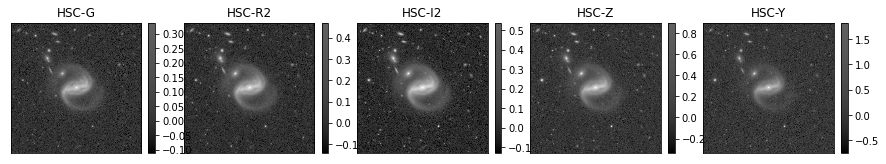

In [11]:
fig, ax = plt.subplots(1,5, figsize=(15, 5))
display = []
for i in range(len(bands)):
    plt.sca(ax[i])
    afw_display = afwDisplay.Display(frame=fig)
    display.append(afw_display)
    display[i].scale("asinh", "zscale")
    display[i].setMaskTransparency(100)
    display[i].mtv(calexps[bands[i]])
    ax[i].set_title(bands[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

Now we compare the original RGB output (from the default showRGB function) and the scaled RGB image explored here. This function requires specifically a multiband exposure object to work with, so first we construct one of those.

In [12]:
# Multiband exposures need a list of images and filters
coadds = [calexps[bnd] for bnd in bands]
coadds = MultibandExposure.fromExposures(bands, coadds)

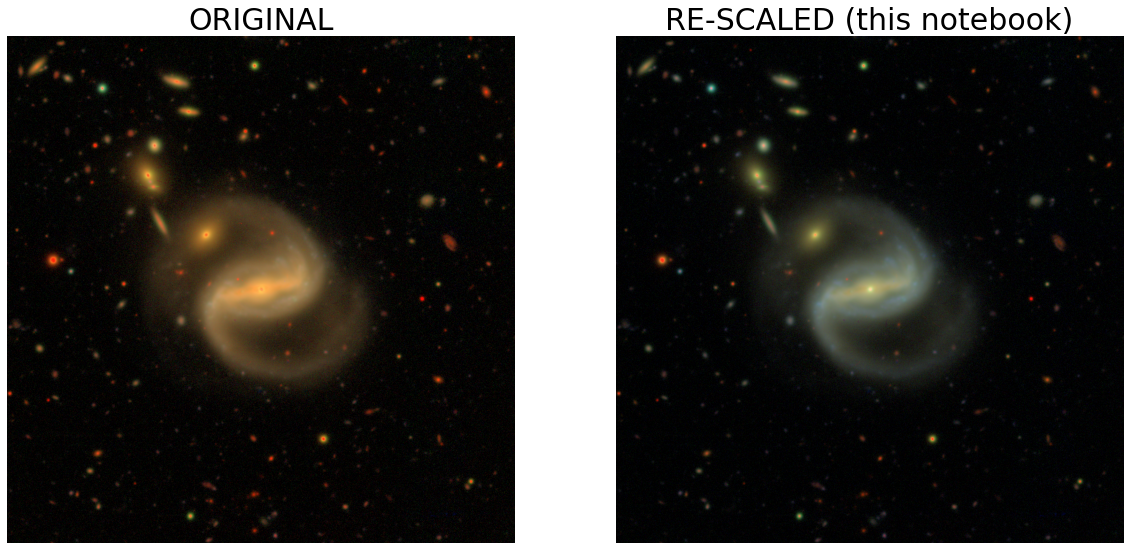

In [13]:
fig, ax = plt.subplots(figsize=(20, 20), nrows=1, ncols=2)

##original make_lupton_rgb without any scaling 
rgb_original = showRGB(coadds[:"HSC-Y"].image, bgr=bands, scale=None)
ax[0].imshow(rgb_original, origin='lower')
ax[0].set_title('ORIGINAL', fontsize=30)

##make_lupton_rgb with scaled rgb channels (this notebook) 
ax[1].set_title('RE-SCALED (this notebook)', fontsize=30)
rgb_scaled = showRGB(coadds[:"HSC-Y"].image, bgr=bands, scale=[0.5, 0.7, 1.0])
ax[1].imshow(rgb_scaled, origin='lower')

ax[0].set_axis_off()
ax[1].set_axis_off()
plt.show()

Everything looks to be in order, so now we can prepare the images for photometry.

First we need to elliptical parameters of the galaxy.  We'll do this visually, so our initial guess is position angle of 150 degrees, and axial ratio of 0.9:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


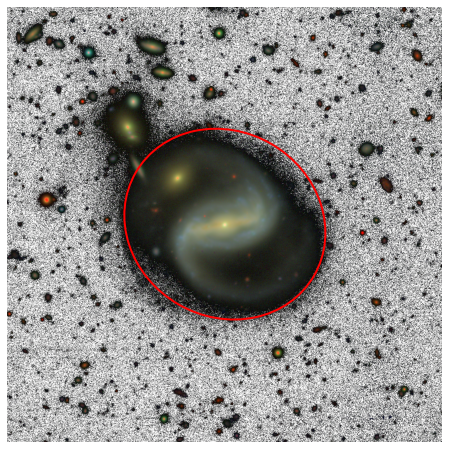

In [14]:
# We will use the I2 band, which looks comparitively deep
image_I2 = calexps['HSC-I2'].image.array
xcen = image_I2.shape[1]//2
ycen = image_I2.shape[0]//2
cen = (xcen, ycen)
PA = 150
q = 0.9
size = 450 

ellipse = Ellipse(xy=cen, width=size, height=size*q, angle= PA,\
                  edgecolor='red', fc='None', lw=2, zorder = 2)

# Here we add a luminance channel to view the outskirts of the object in grey scale
rgb_alpha = np.stack([rgb_scaled[:,:,0], 
                      rgb_scaled[:,:,1], 
                      rgb_scaled[:,:,2],
                      np.sum(rgb_scaled, axis=2)*10], 
                     axis=2)

plt.figure(figsize=(8,8))
plt.imshow(rgb_alpha, origin='bottom')
plt.gca().add_patch(ellipse)

plt.axis('off')

plt.show()

## **Part 3: Masking unwanted sources**

First we will set up our deblender and detection tasks.  This is using the [lsst_stack_deblender tutorial](https://github.com/LSSTScienceCollaborations/StackClub/blob/master/Deblending/lsst_stack_deblender.ipynb) as a baseline, so see that page for more detailed information.  We'll use the I2-band for our detection, which in our images above looks to have a deep sensitivity, and falls in a red wavelength regime that should help pick out more high-redshift objects as well.  The goal of detection is to make an initial, harsh mask to block out the galaxy and any external objects.  The goal of the deblending will be to pick out objects embedded within the galaxy for more careful photometry (that excludes blended sources).

### **Detection**

In [19]:
schema = SourceCatalog.Table.makeMinimalSchema() # Set up an empty schema

# The source detection
detectionConfig = SourceDetectionTask.ConfigClass()
detectionConfig.thresholdValue = 1  # This is our detection threshold
detectionConfig.thresholdType = "stdev" # Specifying we want it in standard deviations
detectionTask = SourceDetectionTask(schema=schema) # Set up a detection task for the previous schema

Now we'll run the detection task on the whole cutout to create the initial mask (galaxy + external objects).  Again, we'll use the I-band given its high quality.  Note that detection works using a single photometric band, whereas the Scarlet deblender (which we make use of later) uses multiband images.

In [20]:
detectionTable = SourceCatalog.Table.make(schema)
detectionResult = detectionTask.run(detectionTable, calexps['HSC-I2']) # Using only I-band
detectionCatalog = detectionResult.sources

We'll use the coordinates of the calexp bounding box, along with the indexes and values of the footprints, to pinpoint the locations of the footprints on the image thumbnails.  The bounding box mininum is the lower-left corner of the thumbnail (indexes 0,0), so we just subtract that value from the footprint indices to find our coordinates in thumbnail image space.

We'll also identify and then separate out the footprint that contains the galaxy we're interested in.  We do want to preserve this mask for a later step, that being the local sky background estimation (Part 4).

In [21]:
xy_begin = bbox.getMin()
mask = np.zeros(image_I2.shape) # Masking all detections, except galaxy of interest
sky_mask = np.zeros(image_I2.shape) # Mask all detections, including galaxy of interest, for sky estimation
atol = 50 # Requires a high number: the footprint centroid is not the galaxy centroid

for j in range(len(detectionCatalog['id'])):
    centroid = detectionCatalog[j].getFootprint().getCentroid()
    
    yind, xind = detectionCatalog[j].getFootprint().spans.indices()
    new_yind = np.array(yind, dtype=int) - xy_begin[1] # yind, xind are lists, so we need to convert to do math
    new_xind = np.array(xind, dtype=int) - xy_begin[0]    
    sky_mask[new_yind, new_xind] = np.nan
    
    want1 = np.isclose(centroid[0], xy_begin[0]+bwidth//2, atol=atol)
    want2 = np.isclose(centroid[1], xy_begin[1]+bwidth//2, atol=atol)
    
    if want1 & want2:
        obj_ind = j
        continue
        
    # Now setting all mask pixels to NaN
    # Alternative with our software is to assign values > 0 to a blank image and use as mask array
    mask[new_yind, new_xind] = np.nan

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0, 'X [pixels]')

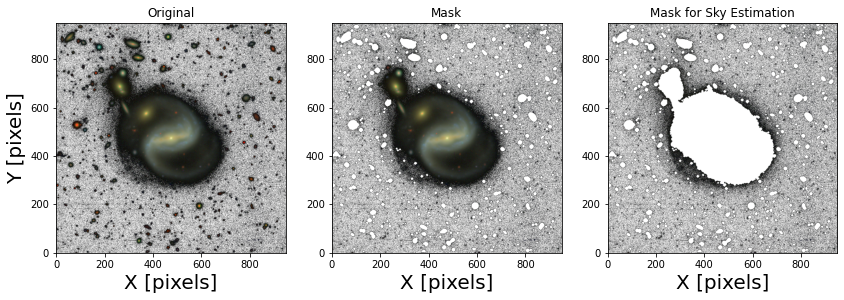

In [22]:
# Checking that our resulting mask makes sense
fig, ax = plt.subplots(figsize=(14, 7), nrows=1, ncols=3)
ax[0].imshow(rgb_alpha, origin='bottom')
ax[0].set_title('Original')
ax[0].set_xlabel('X [pixels]', fontsize=20)
ax[0].set_ylabel('Y [pixels]', fontsize=20)

# Copy the RGB image 
rgb_alpha_copy = copy(rgb_alpha)

for k in range(0, 4):
    rgb_alpha_copy[:,:,k] = rgb_alpha_copy[:,:,k] + mask 

ax[1].imshow(rgb_alpha_copy,  origin='bottom')
ax[1].set_title('Mask')
ax[1].set_xlabel('X [pixels]', fontsize=20)

for k in range(0, 4):
    rgb_alpha_copy[:,:,k] = rgb_alpha_copy[:,:,k] + sky_mask

ax[2].imshow(rgb_alpha_copy,  origin='bottom')
ax[2].set_title('Mask for Sky Estimation')
ax[2].set_xlabel('X [pixels]', fontsize=20)

This shows that we can pick out pixels that belong to everything except the central galaxy and whatever surrounding galaxies are part of the same footprint (right panel) or that we can include the target galaxy mask as well (for background sky estimation, shown in the next section). Note that with even a 1 sigma detection threshold, there is still a lot of diffuse light leaking out from the galaxy outskirts.  This is primarily why we will use a clipped standard deviation and mean for our background estimation (Part 4).

### **Deblending**

Of course, for a more correct mask we also want to include masks around sources overlapping the galaxy.  Because the current implementation of the deblender in the Stack is out of date, we're going to use the following package:

https://github.com/herjy/scarlet_extensions

To run this notebook from this point onward, you will need to do a git clone on this package in your working directory, then move the scarlet_extensions folder out from the newly created repository.  Also, this package requires SEP, a SExtractor protocol for Python.  This can be installed quite easily: `pip install sep` (however, make sure you do it in an LSST environment).

The Scarlet deblending requires specifically a multiband exposure object to work with. We already created this for the showRGB function. However, here we only use the first three filters for deblending.

In [23]:
coadds = coadds[bands[:3]] # Using only the first three filters

In [26]:
images = coadds.image.array
seg_catalog, bg_rms = det.makeCatalog(images)

The object `seg_catalog` is a SExtactor table (use `seg_catalog.dtype` to see the names of the table elements), including position, position angle, and ellipticity estimates.  So we can easily check the output of this segmentation by plotting the output ellipses on the galaxy image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


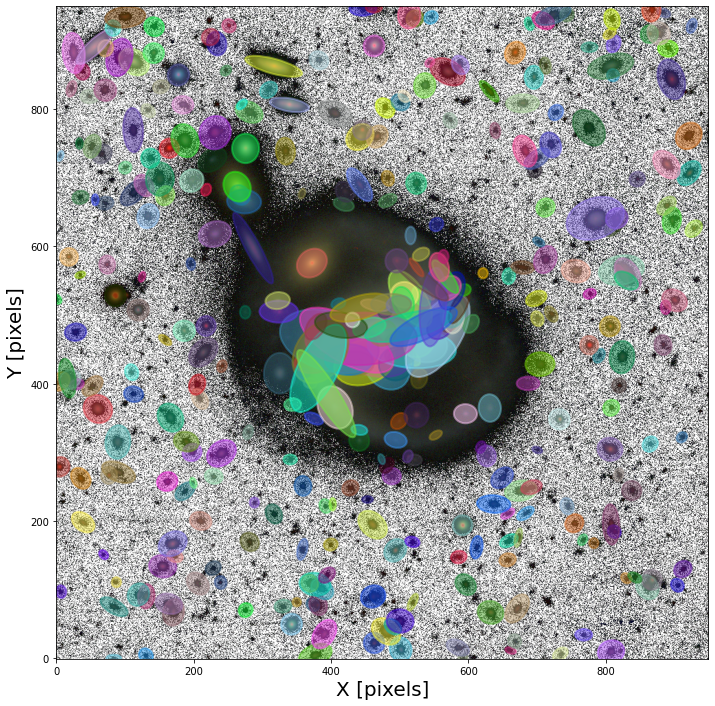

In [28]:
fig, ax = plt.subplots(figsize=(12,12))

# Plot: if you prefer grey-scaled image background only in I2 band
#im = ax.imshow(image_I2, norm=colors.LogNorm(), origin='bottom', cmap='Greys')

# Or re-scaled color image from before 
im = ax.imshow(rgb_alpha, origin='lower')

# Array to assign unique ID for deblended source 
objID = np.arange(start=0, stop=len(seg_catalog), dtype=np.int)
ellipsemask_wIDs = np.zeros(image_I2.shape)

# Then plot an ellipse for each deblender detection
# Colors are randomized to aid in visibility
for i in range(len(seg_catalog)):
    q_obj = seg_catalog['b'][i]/seg_catalog['a'][i]
    
    if q_obj<0.4:
        fac = 6. 
    else:
        fac = 10.
    
    e = Ellipse(xy=(seg_catalog['x'][i], seg_catalog['y'][i]),
                width=2.*fac*seg_catalog['a'][i],
                height=2.*fac*seg_catalog['b'][i],
                angle=seg_catalog['theta'][i] * 180. / np.pi, 
                lw=2)
    
    # Create ellipse around each source to assign objID
    ellipse_dict = mk_ell(image_I2, 
                          seg_catalog['x'][i], 
                          seg_catalog['y'][i], 
                          seg_catalog['theta'][i] * 180. / np.pi - 90., 
                          1.-q_obj)

    ellipsemask_wIDs[(ellipse_dict['ellRad'] < fac*seg_catalog['a'][i])] = objID[i]
    
    color = list(np.random.uniform(size=3))
    color.append(0.5)
    e.set_facecolor(color)
    e.set_edgecolor(color)
    ax.add_artist(e)
    
#plt.axis('off')

ax.set_xlabel('X [pixels]', fontsize=20)
ax.set_ylabel('Y [pixels]', fontsize=20)
plt.show()

#ax.plot(seg_catalog['x'], seg_catalog['y'], 'k.', markersize=5)

We take advantage of Holoviews to (manually and interactively) select deblending sources to be later masked/unmasked. The following function was directly taken from the StackClub repo: Visualization/bokeh_holoviews_datashader.ipynb ([github link](https://github.com/LSSTScienceCollaborations/StackClub/blob/project/bokeh_holoviews_datashader/bechtol/Visualization/bokeh_holoviews_datashader.ipynb)).

We import the relevant packages below (we leave these separated to avoid confusion with the Matplotlib software above).

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
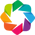

In [30]:
import holoviews as hv
from holoviews import streams
from holoviews.operation.datashader import datashade, dynspread, rasterize
hv.extension('bokeh')

In our case, we need to unmask the deblended central regions of the galaxy as well as expand the mask of the object at (250, 700) that has not been completely masked with the fixed ellipse size selected above. For this reason, we create two Holoview plots so that the user may run seperate cells for masking and unmasking regions.

### Unmasking regions with Holoview

Using the left panel of the following plot, you may draw a region to select points (corresponding to the object masks above) that you want to unmask. 

In [31]:
%%output size=150
%%opts Points [tools=['box_select', 'lasso_select']]

# Declare some points
points = hv.Points((seg_catalog['x'], seg_catalog['y']))

# Declare points as source of selection stream
selection_unmask = streams.Selection1D(source=points)

# Write function that uses the selection indices to slice points and compute stats
def selected_info(index):
    selected = points.iloc[index]
    if index:
        label = 'Mean x, y: %.3f, %.3f' % tuple(selected.array().mean(axis=0))
    else:
        label = 'No selection'
    return selected.relabel(label).options(color='red')

# Combine points and DynamicMap
# Notice the interesting syntax used here: the "+" sign makes side-by-side panels
points + hv.DynamicMap(selected_info, streams=[selection_unmask])

:Layout
   .Points.I     :Points   [x,y]
   .DynamicMap.I :DynamicMap   []
      :Points   [x,y]

To UNMASK a selected region, you can run the cell below. Afterwards, you can make another selection above and repeat this step to unmask other regions if you wish.

In [32]:
unmask_objID_selected = np.array(selection_unmask.index)

# Array with all deblended objects detected as NaN
mask_objects = np.zeros(ellipsemask_wIDs.shape)
mask_objects[ellipsemask_wIDs != 0] = np.nan

# If selected index is objID then unmask

for obj_sel in unmask_objID_selected:
    mask_objects[ellipsemask_wIDs == obj_sel] = 0. 

Let's overplot this new mask on the image to see if we have unmasked what we intended.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'RGB + UNMASKED region')

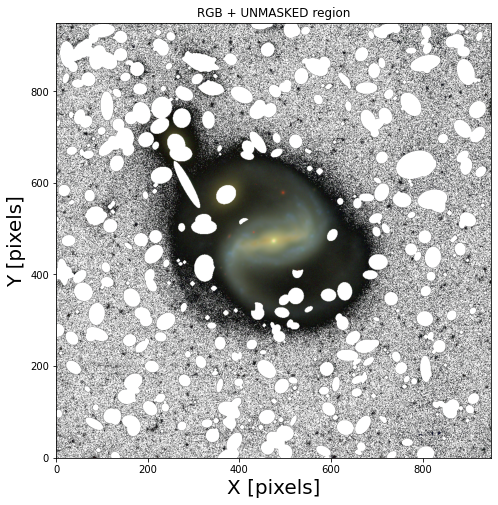

In [33]:
fig, ax = plt.subplots(figsize=(8,8))
#im = ax.imshow(image_I2, norm=colors.LogNorm(), origin='bottom')

rgb_alpha_masked = copy(rgb_alpha)

master_mask = mask_objects + mask # This is our updated mask with the unmasked region 

for k in range(0, 4):
    rgb_alpha_masked[:,:,k] = rgb_alpha_masked[:,:,k] + master_mask 
    
im = ax.imshow(rgb_alpha_masked, origin='bottom')

#loc = ax.plot(seg_catalog['x'], seg_catalog['y'], 'k.', markersize=5)
ax.set_xlabel('X [pixels]', fontsize=20)
ax.set_ylabel('Y [pixels]', fontsize=20)
plt.title('RGB + UNMASKED region')

### Masking regions with Holoview

Using the left panel of the following plot, you may draw a region to select points (corresponding to the object masks above) that you want to mask, in the same manner as the previous unmasking step. 

In [37]:
%%output size=150
%%opts Points [tools=['box_select', 'lasso_select']]

# Declare points as source of selection stream
selection_mask = streams.Selection1D(source=points)

# Combine points and DynamicMap
points + hv.DynamicMap(selected_info, streams=[selection_mask])

:Layout
   .Points.I     :Points   [x,y]
   .DynamicMap.I :DynamicMap   []
      :Points   [x,y]

To MASK the selected region, you may run the cell below. For this particular example, both the UNMASK and MASK cells here need to be run to mask the sources surrounding the object of interest appropriately. 

In [45]:
mask_objID_selected = selection_mask.index

# We intend to expand the ellipses of the sources selected by a user specified factor value 'fac'
fac= 30 

# Create bigger ellipse around each selected source above

for i in mask_objID_selected:
    ellipse_dict = mk_ell(image_I2, 
                          seg_catalog['x'][i], 
                          seg_catalog['y'][i], 
                          seg_catalog['theta'][i] * 180. / np.pi - 90., 
                          1.-q_obj)

    ellipsemask_wIDs[(ellipse_dict['ellRad'] < fac*seg_catalog['a'][i])] = i
    
    # Update mask_objects 
    mask_objects[(ellipsemask_wIDs == np.float(i))] = np.nan

Let's plot the new, updated mask to see if we have managed to mask the source at (250, 700).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'RGB + UNMASKED + MASKED regions')

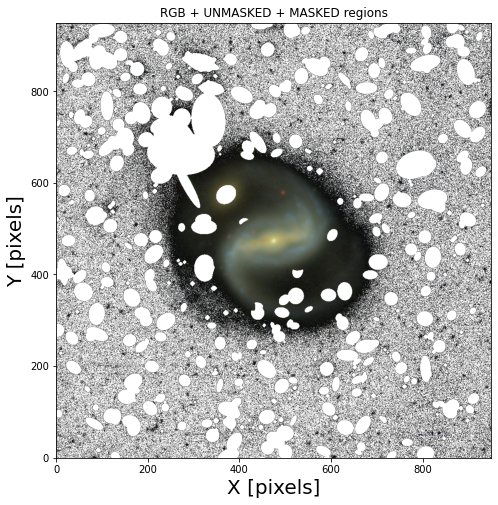

In [46]:
fig, ax = plt.subplots(figsize=(8,8))
#im = ax.imshow(image_I2, norm=colors.LogNorm(), origin='bottom')

master_mask = mask_objects + mask #this should now be our final mask 

for k in range(0, 4):
    rgb_alpha_masked[:,:,k] = rgb_alpha_masked[:,:,k] + master_mask 
    
im = ax.imshow(rgb_alpha_masked, origin='bottom')

#loc = ax.plot(seg_catalog['x'], seg_catalog['y'], 'k.', markersize=5)
ax.set_xlabel('X [pixels]', fontsize=20)
ax.set_ylabel('Y [pixels]', fontsize=20)
plt.title('RGB + UNMASKED + MASKED regions')

Once you visually verify that the obvious sources surrounding the galaxy have been masked, we can proceed to the next step!

## **Part 4: Sky Background Estimation**

In order to do accurate surface photometry, we need an estimate of the local background, to correct for over- or under-subtraction of the sky local to the galaxy.  We will do this using a fairly traditional method, by determining the mean values in a sample of equal-area boxes containing unmasked pixels.  We distribute these boxes randomly in position about the cutout, rejecting boxes if they contain more than 50% masked pixels.

In [47]:
from astropy.stats import sigma_clipped_stats
meanflux_I2 = np.zeros(1000)
sky_pixels = sky_mask + image_I2

# Setting up random state for box distribution
local_state = np.random.RandomState(2)
dim2, dim1 = sky_pixels.shape # Need to keep boxes within the image cutout
# Sky box size will be 100 x 100 pixels
length = 100
height = 100
for k in range(0, 1000):    
    xc, yc = local_state.randint(low=101, high=dim1-101, size=2)
    # Ensuring the boxes land fully within the image cutout
    x0 = np.round(xc-length//2)
    x1 = np.round(xc+length//2)
    y0 = np.round(yc-height//2)
    y1 = np.round(yc+height//2) 
    
    if x0 < 0: x0 = 0
    if x1 > dim1: x1 = dim1-1
    if y0 < 0: y0 = 0
    if y1 > dim2: y1 = dim2-1
        
    pixels = sky_pixels[y0:y1,x0:x1]    
    if len(np.isfinite(pixels)[np.isfinite(pixels)]) < 0.5*len(pixels):
        meanflux_I2[k] = np.nan
        continue    
    meanflux_I2[k] = np.nanmean(np.ravel(pixels))

stats = sigma_clipped_stats(meanflux_I2[~np.isnan(meanflux_I2)], sigma=3.0)
mean_sky_I2 = stats[1]
sigma_I2_sky = stats[2]
print('Mean background value: {:.3f}'.format(mean_sky_I2))
print('Standard Deviation: {:.3f}'.format(sigma_I2_sky ))

Mean background value: 0.002
Standard Deviation: 0.008


From this, we can see that the background value beyond the galaxy is close to 0 in these units.  From our quick check above, we can see what the standard deviation is in surface brightness, which will give us a rough estimate of the depth of this image (in the I-band) down to the noise limit.  We'll use our magnitude zeropoint and pixel scale that we grabbed much earlier.

In [48]:
mu_lim_I2 = -2.5*np.log10(sigma_I2_sky) + magZp + 2.5*np.log10(pxScale**2)
print('Limiting surface brightness in I-band is: {:.2f} mag/arcsec^2'.format(mu_lim_I2))

Limiting surface brightness in I-band is: 28.37 mag/arcsec^2


## **Part 5: Surface brightness profiles**

Now that we have appropriate masks, and now that we know the background sky value, we can create surface brightness profiles of the galaxy. 

We need the measured elliptical parameters for the galaxy (to characterise its global 2D shape) to compute the average brightness within elliptical annuli increasing in distance from the center of the galaxy. We visualise how this is computed below.

In [49]:
image_source_and_sky = image_I2 + master_mask

def to_mags(phot_dict, magZp=magZp):
    scale_term = 2.5*np.log10(pxScale**2)
    intens = phot_dict['mean_I'] # Using mean for now; median likely similar
    mu = -2.5*np.log10(intens) + magZp + scale_term
    rad = phot_dict['rad']*pxScale # Radius returned in arcseconds
    
    mu[~np.isfinite(mu)] = 999
    
    return mu, rad
    
photometry = {}
phot_dict = surfbprof(image_source_and_sky - mean_sky_I2, # Using only the model+sky subtraction
                      image_I2*0.0, 
                      cen, 
                      PA, 
                      1-q,
                      2, image_I2.shape[0]//2-1, iflag=0)

photometry['HSC-I2'] = phot_dict

photometry['HSC-I2']['mu'], photometry['HSC-I2']['rad_as'] = to_mags(photometry['HSC-I2'])

/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


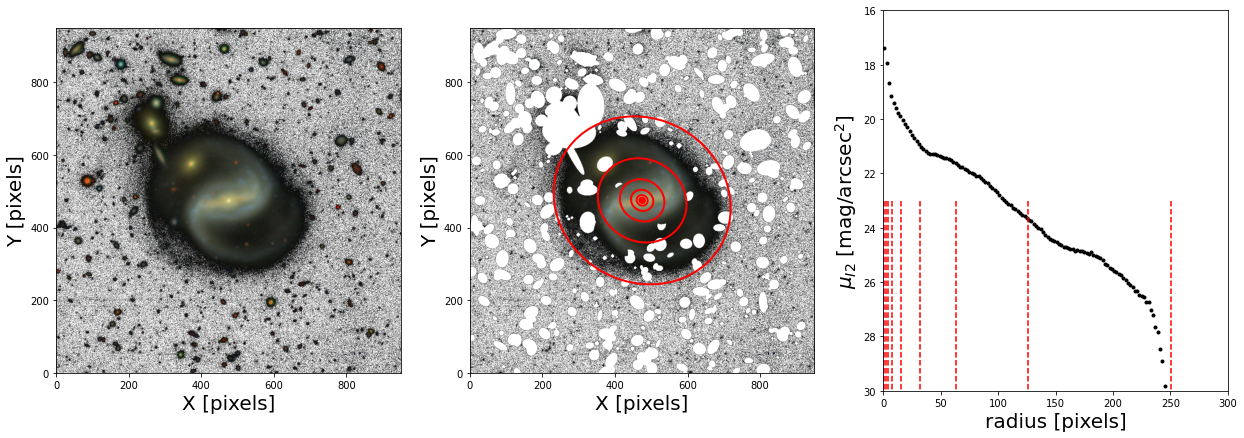

In [50]:
photo_I2 = photometry['HSC-I2']
rad = photo_I2['rad']
sb = photo_I2['mu']

# Geimage (working with HSC g band)
fig, ax = plt.subplots(figsize=(21,7), nrows=1, ncols=3)

ax[0].imshow(rgb_alpha, norm=colors.LogNorm(), origin='bottom')
ax[0].set_xlabel('X [pixels]', fontsize=20)
ax[0].set_ylabel('Y [pixels]', fontsize=20)
    
ax[1].imshow(rgb_alpha_masked, norm=colors.LogNorm(), origin='bottom')
ax[1].set_xlabel('X [pixels]', fontsize=20)
ax[1].set_ylabel('Y [pixels]', fontsize=20)

# Now plot a handful of bins to demonstrate isophotes
bins = np.logspace(0.0, np.log10(500.0), num=10)

for k in range(0, len(bins)):
    # Plot ellipse at each radius in red
    ellipse = Ellipse(xy=cen, width=bins[k], height=bins[k]*q, angle= PA,\
                      edgecolor='red', fc='None', lw=2, zorder = 2)

    ax[1].add_patch(ellipse)
    
# Finally, plotting resulting surface brightness profile 
mu_bins = np.linspace(23, 34, num=10)

ax[2].plot(rad, sb, 'k.')
ax[2].set_ylim(16, 30)
ax[2].set_xlim(0, 300)

for i in range(0, len(bins)):
    ax[2].plot(np.ones(len(mu_bins))*bins[i], mu_bins, 'r--')

ax[2].invert_yaxis()
ax[2].set_ylabel(r'$\mu_{I2}$ [mag/arcsec$^2$]', fontsize=20)
ax[2].set_xlabel('radius [pixels]', fontsize=20)
plt.show()

The left panel shows the galaxy in a log scale, with the color image embedded at high surface brightness.  The central panel shows the same, but with a handful of ellipses marking the isophote shapes we are using to calculate the surface brightness profile.  Finally, the actual surface brightness profile is shown in the rightmost panel, with vertical lines showing the locations of the ellipses in the center panel.

We can see it has a fairly typical barred galaxy profile: a bulge in the center, a slight depression around 30 pixels where the bar's unstable Lagrange points have cleared out the stellar populations, humps demarcating the inner and outer rings, and a generally exponential decline.  We note that around 230 pixels in radius, however, there is a drastic decline in surface brightness.  This occurs well above the noise limit we calculated earlier (closer to 27 than to the ~28.5 limit from the background scatter), implying either a sharp disk truncation, or a systematic oversubtraction during the image reduction.

This was done using the PDR2-equivalent pipeline, suggesting that this pipeline's sky subtraction still manages to under-estimate flux for large angular-sized objects and low surface brightness objects to some extent.